# Упражнение 2

Цель упражнения - применить на практике инструменты работы с текстом.

Дан файл, который получен с помощью API уже знакомого ресурса op.itmo.ru (эндпойнт https://op.itmo.ru/api/item/)

In [ ]:
import warnings
import json
from typing import Optional, Set, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Задание 2.0

Сформируем датасет, с которым будет удобно работать.

In [ ]:
study_items_data_original = pd.read_excel("../data/items.xlsx", usecols=["id", "name", "domain", "value"])  # noqa

In [ ]:
display(study_items_data_original.shape)
display(study_items_data_original.sample(5))

(22160, 4)

,id,name,domain,value
16512,15333,Дефектоскопия материалов,"{'id': 117, 'name': 'Материаловедение'}",2
14547,16899,Способы сохранения интеллекта,NaN,0
12951,15044,Информационная безопасность Российской Федерации,"{'id': 180, 'name': 'Информационная безопаснос...",0
1629,2166,Моделирование бизнес-процессов,"{'id': 17, 'name': 'Информационные технологии'}",59
13390,22398,Geothermal energy,"{'id': 25, 'name': 'Экология'}",4


In [ ]:
study_items_data = study_items_data_original.copy()

**Посмотрим описание данных**

In [ ]:
study_items_data.describe()

,id,value
count,22160.000000,22160.000000
mean,14120.281453,7.823782
std,7764.219561,17.238547
min,2.000000,-10.000000
25%,7232.750000,0.000000
50%,14370.500000,2.000000
75%,21122.750000,9.000000
max,26853.000000,513.000000


**Оценим количество NaN в domain**

In [ ]:
study_items_data.domain.isna().sum() / study_items_data.shape[0]

0.1325361010830325

Таких данных довольно большое количество - 13%, мы не можем их удалить.

**Создадим новый домен - {"id": 0, "name": "Неопределённый"}**

In [ ]:
study_items_data.domain = study_items_data.domain.fillna('{"id": 0, "name": "Неопределённый"}')

In [ ]:
study_items_data.domain.isna().sum() / study_items_data.shape[0]

0.0

**Приведём domain к виду, с которым удобно работать**

In [ ]:
def split_domain(row: Optional[str]) -> pd.Series:
    row_dict = json.loads(row.replace("'", '"'))
    return pd.Series([row_dict["id"], row_dict["name"]], index=["domain_id", "domain_name"])

In [ ]:
study_items_data[["domain_id", "domain_name"]] = study_items_data.domain.apply(split_domain)
study_items_data.drop(columns=["domain"], inplace=True)

In [ ]:
study_items_data = study_items_data.astype({"domain_id": int})

In [ ]:
display(study_items_data.shape)
display(study_items_data.sample(5))

(22160, 5)

,id,name,value,domain_id,domain_name
21893,26599,Современные проблемы экономического функционир...,1,40,Экономика и финансы
17998,20367,Critical analysis of problem situations using ...,2,30,Soft Skills
20258,25171,Modern Marketing Concepts,2,40,Экономика и финансы
4025,4834,Полимеразная цепная реакция,15,21,Биотехнологии
19131,21268,Школьный курс химии,3,24,Химия


## Задание 2.1

**Посчитаем количество предметных областей**

Учтём, что одну мы создали сами.

In [ ]:
print(f"Количество предметных областей: {study_items_data.domain_id.unique().shape[0] - 1} + 1 неопределённый")

Количество предметных областей: 61 + 1 неопределённый


**Найдём объём каждой из предметных областей**

In [ ]:
count_names_df = study_items_data.groupby(["domain_id", "domain_name"]).agg({"name": "nunique"}).reset_index()
count_names_df.columns = ["domain_id", "domain_name", "count_names"]
count_names_df.sort_values(by="count_names", ascending=False, inplace=True)
count_names_df.head(5)

,domain_id,domain_name,count_names
5,17,Информационные технологии,3672
0,0,Неопределённый,2937
8,20,Физика,2763
9,21,Биотехнологии,1263
24,40,Экономика и финансы,1075


**Визуализируем данные датафрейма**

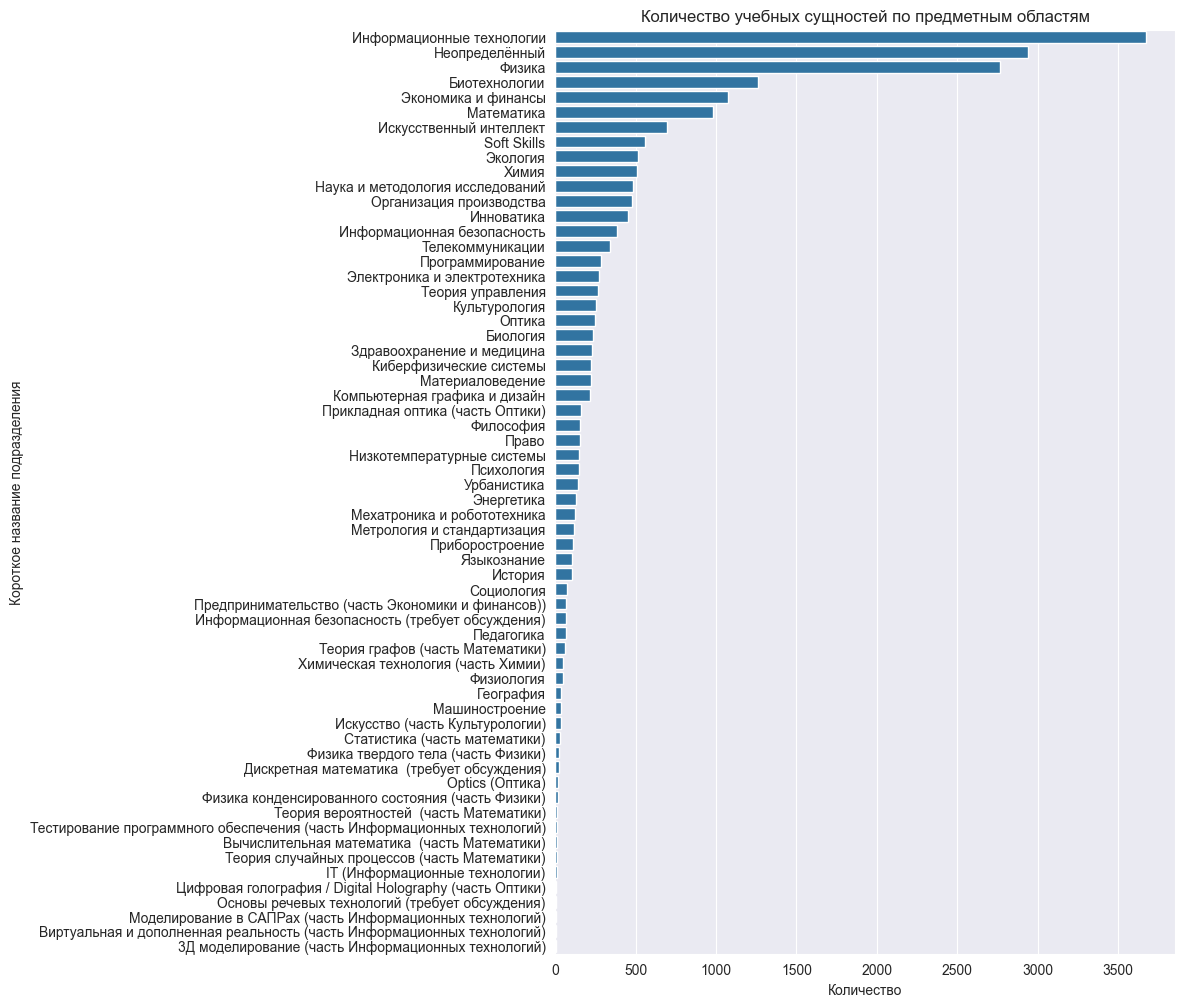

In [ ]:
plt.figure(figsize=(8, 12))
plt.title("Количество учебных сущностей по предметным областям")
sns.set_palette("pastel")
sns.barplot(x=count_names_df.count_names, y=count_names_df.domain_name, orient="h")
plt.xlabel("Количество")
plt.ylabel("Короткое название подразделения")
plt.show()

## Задание 2.2

**Посчитаем количество слов учебных сущностях**

In [ ]:
study_entity_names_df = study_items_data[["id", "name"]]
study_entity_names_df["num_words"] = study_entity_names_df.name.apply(lambda x: len(x.split()))

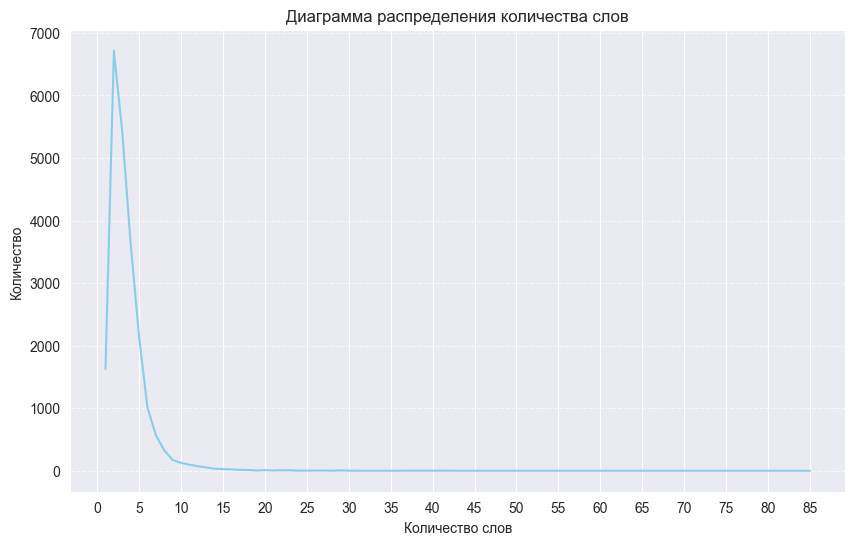

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(study_entity_names_df.groupby(by="num_words")["id"].nunique(), color="skyblue")
plt.xticks(np.arange(0, 86, 5))
plt.xlabel("Количество слов")
plt.ylabel("Количество")
plt.title("Диаграмма распределения количества слов")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Выведем первые 25 сущностей по длине name**

In [ ]:
study_entity_names_df.sort_values(by="num_words", ascending=False).head(25)

,id,name,num_words
14949,19806,определять степени принадлежности элементов за...,85
17462,19825,навыки решения следующих практических задач: п...,72
17581,19828,навыки решения следующих практических задач: п...,71
17476,19823,"умение доказывать, что: заданный неограф являе...",66
233,19814,навыки решения следующих практических задач: н...,57
17512,19839,навыки решения следующих практических задач: п...,53
448,21853,Результатом освоения дисциплины должно стать ф...,50
22019,26723,"Able to independently acquire, develop and app...",45
500,20677,Знание базовых понятий физиологических механи...,43
15829,19805,применять на практике знания терминологическог...,41


## Задание 2.3

**Напишем метод для определения некорректных названий**

В современном русском языке 10 знаков препинания: точка, вопросительный знак, восклицательный знак, многоточие, двоеточие, точка с запятой, запятая, тире, двойное тире. Условно знаками препинания можно также считать кавычки.

In [ ]:
INVALID_LAST_SYMBOLS = """.?!:;,-"' """
def is_name_faulty(name: str) -> bool:
    first_letter = name[0]
    if first_letter != first_letter.upper():
        return True

    return name[-1] in INVALID_LAST_SYMBOLS

In [ ]:
faulty_names_df = study_items_data[study_items_data.name.apply(is_name_faulty)]
display(faulty_names_df.shape)
display(faulty_names_df.sample(5))

(451, 5)

,id,name,value,domain_id,domain_name
5400,23372,методология процесса проектирования инноваций,2,283,Инноватика
9154,22283,evaluation,2,180,Информационная безопасность
22047,26751,spoken English,1,26,Языкознание
1546,23802,electrical engineering,0,56,Электроника и электротехника
18006,20358,Отслеживание и анализ результатов тестирования...,3,17,Информационные технологии


**Выведем все такие сущности**

In [ ]:
faulty_items_dict = {}
for _, row in faulty_names_df.iterrows():
    domain_name, item_id, item_name = row[["domain_name", "id", "name"]]
    if domain_name not in faulty_items_dict: faulty_items_dict[domain_name]= []
    faulty_items_dict[domain_name].append((item_id, item_name))

In [ ]:
for domain_name, faulty_items in faulty_items_dict.items():
    print(f"Название доменной области: {domain_name}")
    for item in faulty_items:
        print(f"- Название некорректной сущности: {item}")

Название доменной области: Физика
- Название некорректной сущности: (23142, 'интегральное уравнение ММ электрического поля и его решение для проволочных структур')
- Название некорректной сущности: (21855, 'Численные методы.')
- Название некорректной сущности: (23727, 'физические процессы, происходящие при прохождении света через волноводы')
- Название некорректной сущности: (23729, 'использовать практический опыт применения оптических волокон    в различных сферах науки и техники')
- Название некорректной сущности: (23210, 'молекулярная спектроскопия')
- Название некорректной сущности: (23303, 'technical systems')
- Название некорректной сущности: (22067, 'методы коммуникации')
- Название некорректной сущности: (23730, 'навыки проведения научно-исследовательских работ в области развития волоконной оптики')
- Название некорректной сущности: (23391, 'Skills of using microfluidics as a modern scientific interdisciplinary tool in solving a scientific problem.')
- Название некорректной сущ

## Задание 2.4

Решим задачу поиска дубликатов как задачу по кластеризации.

**План**
1. Сформировать выборку для работы алгоритма
    * Предобработаем названия учебных сущностей стандартным пайплайном
    * Сформируем векторные представления названий учебных сущностей с помощью предобученных моделей sentence-transformer
    * Используем векторные представления, domain_id и value как параметры
2. Обучим алгоритм кластеризации с подбором гиперпараметров
3. Рассмотрим кластеры с примерами от преподавателя, подберём пороговое значение евклидового расстояния, значения ниже которого можно рассмотреть как дубликат.
4. Выведем полученные дубликаты на печать.

**Найдём примеры дубликатов в исходных данных**

In [ ]:
display(study_items_data_original[study_items_data_original.name == "Матрица"])
display(study_items_data_original[study_items_data_original.name == "Матрицы"])

,id,name,domain,value
46,237,Матрица,"{'id': 11, 'name': 'Математика'}",98


,id,name,domain,value
899,1274,Матрицы,"{'id': 11, 'name': 'Математика'}",170


In [ ]:
MATRICES_DUPLICATES = [237, 1274]

In [ ]:
display(study_items_data_original[study_items_data_original.name == "Git"])
display(study_items_data_original[study_items_data_original.name == "GIT"])
display(study_items_data_original[study_items_data_original.name == "Навыки работы с Git"])
display(study_items_data_original[study_items_data_original.name == "Система контроля версий git"])

,id,name,domain,value
12152,14216,Git,NaN,0


,id,name,domain,value
14061,16307,GIT,NaN,0


,id,name,domain,value
14452,24047,Навыки работы с Git,"{'id': 17, 'name': 'Информационные технологии'}",1


,id,name,domain,value
20665,8963,Система контроля версий git,"{'id': 17, 'name': 'Информационные технологии'}",14


In [ ]:
GIT_DUPLICATES = [14216, 16307, 24047, 8963]

**Очистим данные**

In [ ]:
training_data = study_items_data.copy()[["id", "name", "value", "domain_id"]]
training_data.sample(3)

,name,value,domain_id
11076,Структура проекта,-1,0
10228,BI-системы,1,17
4537,Анализ размерности данных,-1,14


### Этап 1

In [ ]:
from ml_data_engine import DataProcessor, YAMLConfigParser

**Предобработаем данные с помощью написанного мной пакета**

Шаги:
1. Нижний регистр
2. Удаление цифр
3. Лемматизация
4. Удаление стоп-слов
5. Удаление спец-символов
6. Удаление лишних пробелов

In [ ]:
dp = DataProcessor(YAMLConfigParser("../configs/preprocessing.yaml"))

In [ ]:
training_data = dp.process_dataframe_text(training_data, ["name"])

In [ ]:
training_data.sample(3)

,name,value,domain_id
4107,декартов замкнутый категория,17,11
11589,квантовый усилитель,-1,0
2280,байесовский сеть доверие,-4,14


In [ ]:
training_data.to_csv("../data/study_entities_train_22000.csv", sep=";", encoding="utf-8", index=False)

In [ ]:
training_data = pd.read_csv("../data/study_entities_train_22000.csv", sep=";", encoding="utf-8")

**Используем sentence-transformer для получения векторных представлений**

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

In [ ]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [ ]:
def vectorize(sentence: str, model: SentenceTransformer) -> np.ndarray:
    return model.encode(sentence).tolist()

In [ ]:
training_data["avg_vector"] = training_data.name.apply(vectorize, args=(model, ))

In [ ]:
training_data.to_csv("../data/vectorized_study_entities_train_22000.csv", sep=";", encoding="utf-8", index=False)

In [ ]:
training_data.sample(3)

,name,value,domain_id,avg_vector
13374,optoelectronic semiconductor devices,1,56,"[0.03337373211979866, 0.03748726844787598, -0...."
5089,алгоритм предварительный обработка видеоданные,8,17,"[0.008026237599551678, 0.017403094097971916, -..."
17479,separation of heterogeneous moving media,0,25,"[-0.05731106176972389, -0.007227304857224226, ..."


In [ ]:
MODEL_VECTOR_SIZE = 512
column_names = [f"vector_{i + 1}" for i in range(MODEL_VECTOR_SIZE)]
training_data[column_names] = pd.DataFrame(training_data.avg_vector.tolist(), index=training_data.index)

In [ ]:
training_data.drop(columns=["avg_vector", "name"], inplace=True)
training_data.sample(3)

,value,domain_id,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,...,vector_503,vector_504,vector_505,vector_506,vector_507,vector_508,vector_509,vector_510,vector_511,vector_512
9549,-1,17,0.049415,0.019889,-0.002646,0.040137,0.076020,-0.001567,-0.001890,-0.066388,...,0.012250,0.038513,0.021225,0.065640,0.018538,-0.046853,-0.072032,0.041673,-0.032864,0.001688
16441,0,24,-0.003677,0.096964,0.024812,0.022651,-0.013557,-0.001734,0.024172,-0.008712,...,0.044985,0.063925,-0.016136,0.025983,-0.016067,-0.076122,-0.040272,0.005703,0.003844,-0.003607
18671,0,56,-0.030612,0.012535,0.002294,-0.030761,0.041163,0.083384,0.009789,-0.056533,...,-0.019977,0.021359,-0.016619,0.005097,0.003865,-0.043468,-0.059420,-0.025387,0.046941,-0.041285


In [ ]:
training_data["id"] = study_items_data_original.id

In [ ]:
training_data.to_csv("../data/vectorized_study_entities_train_22000.csv", sep=";", encoding="utf-8", index=False)

**Применим One-Hot-Encoding на значение категории - domain_id**

In [ ]:
training_data = pd.read_csv("../data/vectorized_study_entities_train_22000.csv", sep=";", encoding="utf-8")
training_data.sample(3)

,value,domain_id,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,...,vector_504,vector_505,vector_506,vector_507,vector_508,vector_509,vector_510,vector_511,vector_512,id
9186,4,17,0.018504,0.065974,-0.042524,0.046925,0.019372,-0.056720,-0.005499,0.001588,...,0.056909,0.033398,-0.011261,0.001664,-0.040883,-0.124522,0.070842,-0.010962,0.040953,24681
6791,11,20,-0.042706,-0.012632,0.004378,-0.010993,0.069158,-0.023215,-0.018780,-0.049017,...,-0.007840,0.007115,0.008091,-0.023521,-0.087759,0.024853,0.019061,0.023458,-0.000605,7878
7480,9,20,0.044277,0.080423,0.012968,-0.016393,0.053034,0.031001,0.038863,-0.041911,...,-0.012778,0.064878,0.059407,0.064799,0.048020,0.009203,0.033550,0.047082,-0.028031,8671


In [ ]:
encoded_domain_df = pd.get_dummies(training_data["domain_id"], prefix="domain_id")
encoded_domain_df.sample(3)

,domain_id_0,domain_id_11,domain_id_14,domain_id_15,domain_id_16,domain_id_17,domain_id_18,domain_id_19,domain_id_20,domain_id_21,...,domain_id_413,domain_id_414,domain_id_415,domain_id_416,domain_id_418,domain_id_419,domain_id_421,domain_id_422,domain_id_423,domain_id_424
19812,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7093,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
training_data = pd.concat([training_data, encoded_domain_df], axis=1)

In [ ]:
training_data.drop(columns=["domain_id"], inplace=True)
training_data.shape

(22160, 576)

**Нормализуем значения value**

In [ ]:
min_value = training_data.value.min()
max_value = training_data.value.max()
training_data.value = (training_data.value - min_value) / (max_value - min_value)

In [ ]:
training_data.sample(3)

,value,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,domain_id_413,domain_id_414,domain_id_415,domain_id_416,domain_id_418,domain_id_419,domain_id_421,domain_id_422,domain_id_423,domain_id_424
1302,0.053537,-0.063334,-0.013886,0.073015,0.020950,0.049919,0.002957,0.147307,-0.002088,0.022376,...,False,False,False,False,False,False,False,False,False,False
13194,0.019120,-0.072708,0.000337,-0.013837,0.010153,0.047416,-0.030344,-0.001575,0.027463,0.034715,...,False,False,False,False,False,False,False,False,False,False
15743,0.026769,-0.062236,0.060779,-0.011451,0.053563,0.035387,0.048599,-0.013037,-0.045550,0.017993,...,False,False,False,False,False,False,False,False,False,False


**Итог: сформировали выборку для кластеризации**

### Этап 2

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances

**Протестируем самый популярный алгоритм KMeans**

In [ ]:
param_grid = {'n_clusters': [5750, 5875, 6000, 6125, 6250]}

In [ ]:
grid_search_k_means = GridSearchCV(KMeans(), param_grid, cv=5, verbose=5)
grid_search_k_means.fit(training_data.drop(columns=["id"]))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............n_clusters=5750;, score=-2166.114 total time=  32.1s
[CV 2/5] END ...............n_clusters=5750;, score=-2163.253 total time=  31.0s
[CV 3/5] END ...............n_clusters=5750;, score=-1989.584 total time=  29.8s
[CV 4/5] END ...............n_clusters=5750;, score=-2031.268 total time=  34.1s
[CV 5/5] END ...............n_clusters=5750;, score=-2387.049 total time=  30.7s
[CV 1/5] END ...............n_clusters=5875;, score=-2156.466 total time=  31.6s
[CV 2/5] END ...............n_clusters=5875;, score=-2164.002 total time=  36.1s
[CV 3/5] END ...............n_clusters=5875;, score=-1992.582 total time=  32.0s
[CV 4/5] END ...............n_clusters=5875;, score=-2029.710 total time=  31.5s
[CV 5/5] END ...............n_clusters=5875;, score=-2388.045 total time=  34.1s
[CV 1/5] END ...............n_clusters=6000;, score=-2163.972 total time=  32.1s
[CV 2/5] END ...............n_clusters=6000;, sco

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'n_clusters': [5750, 5875, 6000, 6125, 6250]},
             verbose=5)

In [ ]:
print(grid_search_k_means.best_params_["n_clusters"])
print(f"Best Within-cluster Sum of Squares Score: {grid_search_k_means.best_score_}")

6250
Best Within-cluster Sum of Squares Score: -2144.7987284940373


In [ ]:
clusters = grid_search_k_means.best_estimator_.predict(training_data.drop(columns=["id"]))

In [ ]:
k_means_predictions = training_data.copy()
k_means_predictions["prediction"] = clusters

In [ ]:
k_means_predictions.sample(3)[["id", "prediction"]]

,id,prediction
13907,16171,3194
4606,5462,4239
8773,10087,966


**Итог по этапу 2:**

Получили разбиение выборки на 6250 кластеров.

### Этап 3

**Оценим полученное предсказание на данных изначальных примерах**

In [ ]:
k_means_predictions[k_means_predictions.id.isin(MATRICES_DUPLICATES)][["id", "prediction"]]

,id,prediction
46,237,4399
899,1274,4399


In [ ]:
study_items_data_original[study_items_data_original.id.isin(k_means_predictions[k_means_predictions.prediction == 4399].id)]

,id,name,domain,value
29,241,Ранг матрицы,"{'id': 11, 'name': 'Математика'}",95
46,237,Матрица,"{'id': 11, 'name': 'Математика'}",98
608,23233,Matrices,"{'id': 11, 'name': 'Математика'}",5
899,1274,Матрицы,"{'id': 11, 'name': 'Математика'}",170
16663,18963,Матрица Лапласа,"{'id': 11, 'name': 'Математика'}",1


In [ ]:
k_means_predictions[k_means_predictions.id.isin(GIT_DUPLICATES)][["id", "prediction"]]

,id,prediction
12152,14216,3334
14061,16307,3334
14452,24047,2069
20665,8963,2244


In [ ]:
study_items_data_original[study_items_data_original.id.isin(k_means_predictions[k_means_predictions.prediction == 2069].id)]

,id,name,domain,value
9349,23508,Использование git,"{'id': 17, 'name': 'Информационные технологии'}",0
14452,24047,Навыки работы с Git,"{'id': 17, 'name': 'Информационные технологии'}",1


In [ ]:
study_items_data_original[study_items_data_original.id.isin(k_means_predictions[k_means_predictions.prediction == 2244].id)]

,id,name,domain,value
581,24244,Системы контроля версий ПО,"{'id': 17, 'name': 'Информационные технологии'}",2
3161,3783,Системы контроля версий,"{'id': 17, 'name': 'Информационные технологии'}",23
9260,22353,Система контроля версий,"{'id': 17, 'name': 'Информационные технологии'}",2
9338,22356,Работа с системой контроля версий,"{'id': 17, 'name': 'Информационные технологии'}",0
19489,21639,Контроль и управление работами в PDM-системе,"{'id': 17, 'name': 'Информационные технологии'}",3
20665,8963,Система контроля версий git,"{'id': 17, 'name': 'Информационные технологии'}",14


**Итог**

Видим, что алгоритм показал хорошее качество кластеризации.

Сущности в каждом кластере очень похожи друг на друга, а зачастую выглядят как дубликаты.

### Этап 4

Из примеров, указанных в тексте лабораторной, я могу однозначно выделить как дубликаты сущности:

Матрица - Матрицы
GIT - Git

Оставшиеся примеры сложно однозначно трактовать с учётом ограниченности информации.

**Рассмотрим евклидово расстояние этих примеров**

**Матрицы - Матрица**

In [ ]:
euclidean_distances(k_means_predictions[k_means_predictions.id == 237].drop(columns=["id", "prediction"]),
                    k_means_predictions[k_means_predictions.id == 1274].drop(columns=["id", "prediction"]))

array([[0.1376673]])

**Git - GIT**

In [ ]:
euclidean_distances(k_means_predictions[k_means_predictions.id == 14216].drop(columns=["id", "prediction"]),
                    k_means_predictions[k_means_predictions.id == 16307].drop(columns=["id", "prediction"]))

array([[0.]])

**Как видим, примеров мало, рассмотрим несколько из уже увиденных**

**Система контроля версий - Система контроля версий git**

In [ ]:
euclidean_distances(k_means_predictions[k_means_predictions.id == 22353].drop(columns=["id", "prediction"]),
                    k_means_predictions[k_means_predictions.id == 8963].drop(columns=["id", "prediction"]))

array([[0.70507429]])

**Матрицы - Matrices**

In [ ]:
euclidean_distances(k_means_predictions[k_means_predictions.id == 1274].drop(columns=["id", "prediction"]),
                    k_means_predictions[k_means_predictions.id == 23233].drop(columns=["id", "prediction"]))

array([[0.52971961]])

**Итог замеров**

Так как однозначных критериев для определения дубликатов у нас нет, примем, что любые 2 элемента одного кластера являются дубликатами, если евклидово расстояние между ними <= 0.705074.

**Напишем метод для вывода таких пар**

In [ ]:
DISTANCE_THRESHOLD = 0.705074
CLASS_COUNT = 6250

def are_duplicates(id_1: int, id_2: int) -> bool:
    return euclidean_distances(
        k_means_predictions[k_means_predictions.id == id_1].drop(columns=["id", "prediction"]),
        k_means_predictions[k_means_predictions.id == id_2].drop(columns=["id", "prediction"])
    ) <= DISTANCE_THRESHOLD

def search_duplicates():
    duplicates: Set[Tuple[int, int]] = set()
    for i in range(CLASS_COUNT):
        class_item_ids = k_means_predictions[k_means_predictions.prediction == i].id
        for item_1 in class_item_ids:
            for item_2 in class_item_ids:
                if item_1 == item_2:
                    continue

                if not are_duplicates(item_1, item_2):
                    continue

                duplicates.add((min(item_1, item_2), max(item_1, item_2)))

    return duplicates

**Используем его**

In [ ]:
duplicates = search_duplicates()

**Получили 21513 пары потенциальных дубликатов**

Учтём, что всего пар 22_000^2 ~= 484_000_000.

Т.е. мы выбрали ~0.004% пар.

In [ ]:
print(len(duplicates))

21513


In [ ]:
list(duplicates)[0:5]

[(6529, 14730), (11389, 21114), (5893, 15428), (23558, 26416), (12615, 13435)]

In [ ]:
display(study_items_data_original[study_items_data_original.id == 6529])
display(study_items_data_original[study_items_data_original.id == 14730])

,id,name,domain,value
5585,6529,Задачи робототехники,"{'id': 61, 'name': 'Мехатроника и робототехника'}",17


,id,name,domain,value
12666,14730,Робототехника,"{'id': 61, 'name': 'Мехатроника и робототехника'}",0


In [ ]:
display(study_items_data_original[study_items_data_original.id == 11389])
display(study_items_data_original[study_items_data_original.id == 21114])

,id,name,domain,value
16846,11389,Биотехнологические процессы,"{'id': 21, 'name': 'Биотехнологии'}",4


,id,name,domain,value
18952,21114,Энергоэффективность биотехнологических процессов,"{'id': 21, 'name': 'Биотехнологии'}",3


**Выведенные пары действительно могут быть дубликатами**

**Запишем сущности в файл**

In [ ]:
with open("../reports/duplicates.txt", "w", encoding="utf-8") as fout:
    for id_1, id_2 in duplicates:
        name_1 = study_items_data_original[study_items_data_original.id == id_1].name.iloc[0]
        name_2 = study_items_data_original[study_items_data_original.id == id_2].name.iloc[0]
        print(f"* учебную сущность {id_1} {name_1} нужно объединить с учебной сущностью {id_2} {name_2}", file=fout)

**Выведем несколько строк**

In [ ]:
lines = open("../reports/duplicates.txt", encoding="utf-8").read().splitlines()

In [ ]:
import random
samples = random.sample(range(1, 21514), 5)
samples

[18398, 17008, 6413, 13076, 5768]

In [ ]:
for number in samples:
    print(lines[number])

* учебную сущность 23051 Результаты инновационной деятельности нужно объединить с учебной сущностью 23055 Виды эффектов от инновационной деятельности
* учебную сущность 4869 Работа с токенами нужно объединить с учебной сущностью 23319 Работа с таск-трекером
* учебную сущность 13366 Научно-технологическое развитие нужно объединить с учебной сущностью 20173 Priority areas of scientific and technological development
* учебную сущность 7872 Методы расчета электронных состояний наноструктур нужно объединить с учебной сущностью 22215 Methods for calculating the electronic states of nanostructures
* учебную сущность 5034 Организация маркетинга инновационных проектов нужно объединить с учебной сущностью 24049 Маркетинг проектов


## Итоги по заданию 4

Получили неплохую классификацию для потенциальных дубликатов, которую можно развивать в дальнешем для реального внедрения.

Пути развития, которые я вижу:
- Расширение исходного датасета новыми параметрами, например, описанием дисциплины, количество часов, выделенных на неё и т.п.
- Использование более релевантного векторизатора (дообучение текущей модели на научной / ИТ лексике)
- Более умная обработка текста с раскрытием университетских аббревиатур и т.п.
- Составление бОльшего количества примеров одинаковых сущностей
- Использование более продвинутого алгоритма кластеризации: DBScan / HDBScan / OPTICS и другие.